python 3.7 and pytorch 1.8

# pytorch 搭建word2vec(skip-gram)模型进行embedding转换

- 目的：词汇embedding转换
- 输入：输入文本(text)
- 输出：embedding_lookup矩阵(model.state_dict()["in_embed.weight"])
- 主要步骤：
1. 文本预处理
2. 获取批次训练数据
3. 构建模型及损失器
4. 模型训练
5. 词向量可视化

## 0.全局变量设置

In [2]:
EMBEDDING_DIM = 2  # 词向量维度
PRINT_EVERY = 1000  # 每训练多少步可视化一次
EPOCHS = 1000  # 训练的轮数
BATCH_SIZE = 5  # 每一批训练数据中输入词的个数
N_SAMPLES = 3  # 每个批次中负样本个数， 如现在占目标词比例是3/(5*2)
WINDOW_SIZE = 5  # 周边词窗口大小
FREQ = 0  # 去除低频词的阈值
Dropout_WORDS = False  # 是否进行高频词抽样处理

## 1.文本预处理

In [3]:
from collections import Counter
# 文本预处理
def preprocess(text, freq):
    words = text.lower().split() # 转小写单词
    # 过滤低频词
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > freq]
    return trimmed_words

In [4]:
# 文本id化，建立单词和索引的一一映射
def word_id_mapping(words):
    word2id, id2word = {}, {}
    for word in words:
        if word not in word2id:
            word2id[word] = len(word2id)
            id2word[len(id2word)] = word
    id_words = [word2id[word] for word in words]
    return id_words, word2id, id2word

In [5]:
# 计算单词的频次及负采样概率（抽样及负采样需要）
import numpy as np
import torch
def figure_freq(id_words):
    cnt_words = Counter(id_words) # 单词集合
    cnt_total = len(cnt_words) # 不重复单词个数
    # 建立单词-频次映射 key: id_word, value: freq
    word_freqs = {word: cnt/cnt_total for word, cnt in cnt_words.items()}
    # 根据单词频次计算各id单词负采样概率
    word_probs = np.array((list(word_freqs.values())))
    noise_probs = torch.from_numpy(word_probs**0.75 / np.sum(word_probs**0.75))

    return word_freqs, noise_probs, cnt_words

In [6]:
# 丢弃部分单词
import random
def dropout_words(id_words, word_freqs, cnt_words):
    if Dropout_WORDS:
        # 根据各单词频次计算各单词丢弃概率
        t = 1e-5
        drop_probs = {word: 1-np.sqrt(t/word_freqs[word]) for word in cnt_words}
        # 对文本进行随机丢弃
        trimmed_words = [word for word in id_words if random.random()>drop_probs[word]]
    else:
        trimmed_words = id_words
    return trimmed_words

In [7]:
# 执行函数进行文本预处理

# 导入输入文本
text = "i like dog i like cat i like animal dog cat animal apple cat dog like dog fish milk like dog \
cat eyes like i like apple apple i hate apple i movie book music like cat dog hate cat dog like"

# 文本预处理
words = preprocess(text, FREQ)

# 文本id化，并建立单词和索引的一一映射
id_words, word2id, id2word = word_id_mapping(words)

# 计算单词的频次及负采样概率（抽样及负采样需要）
words_freqs, noise_probs, cnt_words = figure_freq(id_words)

# 丢弃部分单词
id_words = dropout_words(id_words, words_freqs, cnt_words)


## 2. 获取批次训练数据

In [8]:
# 获取指定下标的输入词的周边词
def get_targets(words, idx, window_size):
    # 计算周边词起始位置, 考虑左侧滑动窗口小于0
    start_idx = idx - window_size if (idx-window_size) > 0 else 0
    end_idx = idx + window_size # 右侧如果超过整个words(非当前截断的),下标自动忽略
    targets = words[start_idx:idx] + words[idx+1:end_idx+1]
    return targets

In [9]:
# 获取批次（输入-输出）词对, 词对shape=(batchsize*(2*windowsize), batchsize*(2*windowsize))
def get_batch(words, batch_size, window_size):
    batchs = len(words) // batch_size # 计算最多分几批进行训练
    words = words[:batchs*batch_size] # 仅满足尺寸要求的批训练数据可参与训练

    for idx in range(0, len(words), batch_size):
        batch_X, batch_y = [], []
        cur_batch = words[idx:idx+batch_size] # 当前输入词窗口
        for jdx in range(batch_size):
            x = cur_batch[jdx] # 获取输入词
            y = get_targets(cur_batch, jdx, window_size) # 获取输出词
            # 一个输入对多个输出，为了使输入输出一致，复制x
            batch_X.extend([x]*len(y))
            batch_y.extend(y)
        yield batch_X, batch_y

## 3. 构建模型及损失器

In [10]:
from torch import nn, optim

# 构建skip-gram模型（带负采样）
class SkipGramNeg(nn.Module):
    def __init__(self, n_word, n_embed, noise_probs):
        super(SkipGramNeg, self).__init__()
        self.n_word = n_word # 词向量矩阵行数，即embed_lookup词典大小
        self.n_embed = n_embed # 词向量维度，如google一般300维
        self.noise_probs = noise_probs # 每个id单词作为负样本被抽样的概率
        # 定义词向量层，包括中心词(input)层和目标词(target)层
        self.in_embed = nn.Embedding(n_word, n_embed)
        self.out_embed = nn.Embedding(n_word, n_embed)
        # 词向量层参数初始化
        #self.in_embed.weight.data.uniform_(-1, 1)
        #self.out_embed.weight.data.uniform_(-1, 1)

    # 中心词的前向过程，即获取中心词转化后的词向量(词id对应的行词向量)
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors

    # 目标词的前向过程，即获取目标词转化后的词向量(词id对应的行词向量)
    def forward_target(self, target_words):
        target_vectors = self.out_embed(target_words)
        return target_vectors

    # 负样本词的前向过程，即获取负样本转化后的词向量(被抽样后的词id对应的行词向量)， 同用outembed层
    def forward_noise(self, batch_size, n_samples):
        # 词汇负采样映射(noise_probs)：key:词id. value:负采样可能概率
        # torch.multinomial对input中非0向量进行有放回随机抽样，值越大抽样概率越大
        # 一个batch的target.shape==batch_size*(2*win_size),
        noise_words = torch.multinomial(self.noise_probs,
                                        batch_size*n_samples,
                                        replacement=True)
        noise_vectors = self.out_embed(noise_words).view(
                        batch_size, N_SAMPLES, self.n_embed)
        return noise_vectors


In [11]:
# 构造损失函数
class NegativeSamplingLoss(nn.Module):
    def __init__(self, n_embed):
        super(NegativeSamplingLoss, self).__init__()
        self.n_embed = n_embed # 词向量维度

    def forward(self, input_vectors, target_vectors, noise_vectors):
        batch_size, _ = input_vectors.shape
        # view方法重构输入词， 目标词向量维度
        input_vectors = input_vectors.view(batch_size, self.n_embed, 1)
        target_vectors = target_vectors.view(batch_size, 1, self.n_embed)
        # 计算目标词和负样本损失
        out_loss = torch.bmm(target_vectors, input_vectors).sigmoid().log() # bmm求矩阵乘
        out_loss = out_loss.squeeze() # 维度压缩

        noise_loss = torch.bmm(noise_vectors.neg(), # !
                               input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)
        #综合损失
        return -(out_loss + noise_loss).mean()

In [12]:
# 模型、损失函数、优化器初始化
model = SkipGramNeg(n_word=len(word2id),
                    n_embed=EMBEDDING_DIM, noise_probs=noise_probs)
criterion = NegativeSamplingLoss(n_embed=EMBEDDING_DIM)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## 4. 模型训练

In [13]:
steps = 0
for epoch in range(EPOCHS):
    for input_words, target_words in get_batch(id_words, BATCH_SIZE, WINDOW_SIZE):
        steps += 1
        inputs, targets = torch.LongTensor(
            input_words), torch.LongTensor(target_words)  # 转化为 tensor 格式
        # 输入词、目标词以及噪声词向量
        input_vectors = model.forward_input(inputs)
        target_vectors = model.forward_target(targets)
        batch_size, _ = input_vectors.shape
        noise_vectors = model.forward_noise(batch_size, N_SAMPLES)
        # print(noise_vectors)
        # 计算损失
        loss = criterion(input_vectors, target_vectors, noise_vectors)
        # 打印损失
        if steps % PRINT_EVERY == 0:
            print("loss：", loss)
        # 梯度回传
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

loss： tensor(3.7213, grad_fn=<NegBackward>)
loss： tensor(3.4663, grad_fn=<NegBackward>)
loss： tensor(3.4352, grad_fn=<NegBackward>)
loss： tensor(3.3836, grad_fn=<NegBackward>)
loss： tensor(3.2446, grad_fn=<NegBackward>)
loss： tensor(3.2295, grad_fn=<NegBackward>)
loss： tensor(3.1304, grad_fn=<NegBackward>)
loss： tensor(2.9078, grad_fn=<NegBackward>)


## 5. 词向量可视化

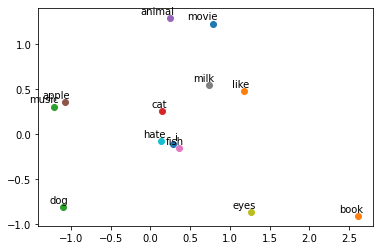

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
for i, w in id2word.items():
    vectors = model.state_dict()["in_embed.weight"]  # 获取输入词的词向量矩阵
    x, y = float(vectors[i][0]), float(vectors[i][1])
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()


